In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.1/107.7 GB disk)


In [8]:
import cv2
from ultralytics import YOLO
import numpy as np
import pandas as pd
import math
from google.colab.patches import cv2_imshow

def process_image(image_file_name, th=0.3):
    def significant_pose_detection(arr, th):
        n = len(arr)
        i = 0
        for itemm in arr:
            if np.sum(itemm[0] + itemm[1]) != 0:
                i += 1
        sig_det = (i / n)
        return 1 if sig_det >= th else 0

    # Load the model
    model = YOLO('yolov8n-pose.pt')
    img = cv2.imread(image_file_name)
    tempimg = cv2.imread(image_file_name)
    results = model.predict(image_file_name)[0]

    Q = []
    det = 0
    concat_df = pd.DataFrame()

    # Extract landmarks
    for result in results:
        landmarks = []
        kpts = result.keypoints
        nk = kpts.shape[1]

        for i in range(nk):
            keypoint = kpts.xy[0, i]
            x, y = int(keypoint[0].item()), int(keypoint[1].item())
            landmarks.append([x, y])

        detections = significant_pose_detection(landmarks, th)
        if detections == 1:
            det += 1
            for j in range(len(landmarks)):
                x = landmarks[j][0]
                y = landmarks[j][1]
                cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
                ttext = f"({x},{y})"
                cv2.putText(img, ttext, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

            df = pd.DataFrame(landmarks, columns=[f'x{det}', f'y{det}'], dtype=float)
            concat_df = pd.concat([concat_df, df], axis=1)

            cv2.line(img, landmarks[11], landmarks[12], (0, 255, 0), 2)
            a = (landmarks[11][0] + landmarks[12][0]) // 2
            b = (landmarks[11][1] + landmarks[12][1]) // 2
            Q.append([a, b])

    m = list(map(lambda l: [v for v in l if v != 0], sorted(Q)))
    nQ = [ele for ele in m if ele != []]

    dict = {}

    sorted_Q = sorted(Q)
    for i, point in enumerate(Q):
        j = sorted_Q.index(point)
        dict[j] = i

    k = len(nQ)

    # Draw lines and centroids
    for i in range(k - 1):
        cv2.line(img, nQ[i], nQ[i + 1], (255, 0, 0), 2)

    for i in range(k):
        cv2.circle(img, nQ[i], 5, (0, 255, 255), -1)
        cv2.circle(img, nQ[i], 7, (0, 0, 255), 2)

    concat_df.to_csv('detected_pose.csv')
    df_nQ = pd.DataFrame(nQ, columns=['x', 'y'], dtype=int)
    df_nQ.to_csv('nQ_centroids.csv')

    print("\n", k, "Persons detected.")
    cv2.imwrite("output.jpg", img)

    # Calculate forces
    numPeople = len(nQ)
    ev = [(nQ[-1][0] - nQ[0][0]), (nQ[-1][1] - nQ[0][1])]
    forces = [[0, 0] for _ in range(numPeople)]
    k = 100

    def findMag(v):
        return math.sqrt(v[0]**2 + v[1]**2)

    def findAngle(p1, p2, ev):
        v12 = [(p1[0] - p2[0]), (p1[1] - p2[1])]
        value = (v12[0] * ev[0] + v12[1] * ev[1]) / (findMag(v12) * findMag(ev))
        return math.acos(value)

    def findDis(p1, p2):
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    for i in range(numPeople - 1):
        theta = findAngle(nQ[i + 1], nQ[i], ev)
        dis = findDis(nQ[i + 1], nQ[i])
        deltaDis = dis * (1 - math.cos(theta))
        forces[i][0] += (k * deltaDis * math.cos(theta))
        forces[i][1] += (k * deltaDis * math.sin(theta) if nQ[i + 1][1] > nQ[i][1] else -k * deltaDis * math.sin(theta))
        forces[i + 1][0] += (-1 * forces[i][0])
        forces[i + 1][1] += (-1 * forces[i][1])

    equivalent = [math.sqrt(force[0]**2 + force[1]**2) for force in forces]

    # Normalize equivalent values to the range 0-255
    equivalent_np = np.array(equivalent)
    equivalent_min = np.min(equivalent_np)
    equivalent_max = np.max(equivalent_np)

    # Apply min-max normalization
    equivalent_np_scaled = ((equivalent_np - equivalent_min) / (equivalent_max - equivalent_min) * 255).astype(np.uint8)

    # Calculate Otsu's threshold
    otsu_threshold, _ = cv2.threshold(equivalent_np_scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    def mark_outliers(nQ, tnet, threshold):
        img_copy = tempimg.copy()
        nQ = np.array(nQ, dtype=int)

        for i in range(len(nQ)):
            if tnet[i] > threshold:
                person_no = dict[i] + 1
                x = concat_df['x' + str(person_no)]
                y = concat_df['y' + str(person_no)]

                x_non_zero = [value for value in x if value != 0]
                y_non_zero = [value for value in y if value != 0]

                min_x = int(min(x_non_zero)) if x_non_zero else 0
                min_y = int(min(y_non_zero)) if y_non_zero else 0
                max_x = int(max(x_non_zero)) if x_non_zero else 0
                max_y = int(max(y_non_zero)) if y_non_zero else 0

                start_point = (min_x, min_y)
                end_point = (max_x, max_y)
                color = (0, 0, 255
                )
                thickness = 2
                img_copy = cv2.rectangle(img_copy, start_point, end_point, color, thickness)

        cv2.imwrite('output_outlier.png', img_copy)
        cv2_imshow(img_copy)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    mark_outliers(nQ, equivalent_np_scaled, otsu_threshold)
    print(equivalent, equivalent_np_scaled, otsu_threshold)


image 1/1 /content/Q3_pose.png: 448x640 12 persons, 241.7ms
Speed: 5.2ms preprocess, 241.7ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

 8 Persons detected.


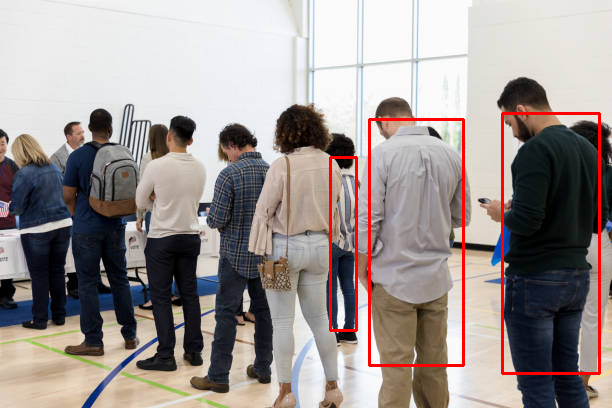

[19.043115592407187, 35.492770966257844, 1.9923663102380107, 142.97873251161008, 78.76454341735342, 485.0640053815162, 425.20021616043687, 425.20021616043687] [  9  17   0  74  40 255 223 223] 74.0


In [9]:
process_image("Q3_pose.png")


image 1/1 /content/Q3_pose3.jpg: 448x640 10 persons, 187.1ms
Speed: 4.8ms preprocess, 187.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

 9 Persons detected.


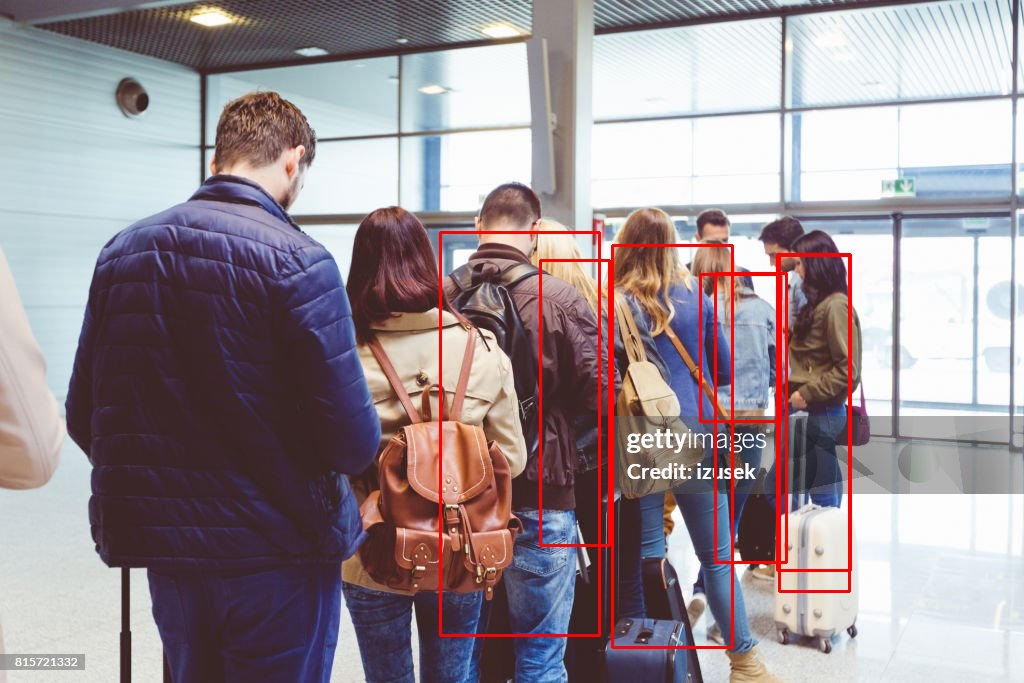

[660.8576979536512, 429.7004421848864, 1249.680300551538, 1187.2703634925617, 1192.8920450779594, 1124.2173962730442, 1311.7064947533431, 1287.4673025667096, 1287.4673025667096] [ 66   0 237 219 220 200 255 247 247] 66.0


In [10]:
process_image("Q3_pose3.jpg")


image 1/1 /content/Q3_pose5.jpg: 448x640 8 persons, 210.7ms
Speed: 6.7ms preprocess, 210.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

 7 Persons detected.


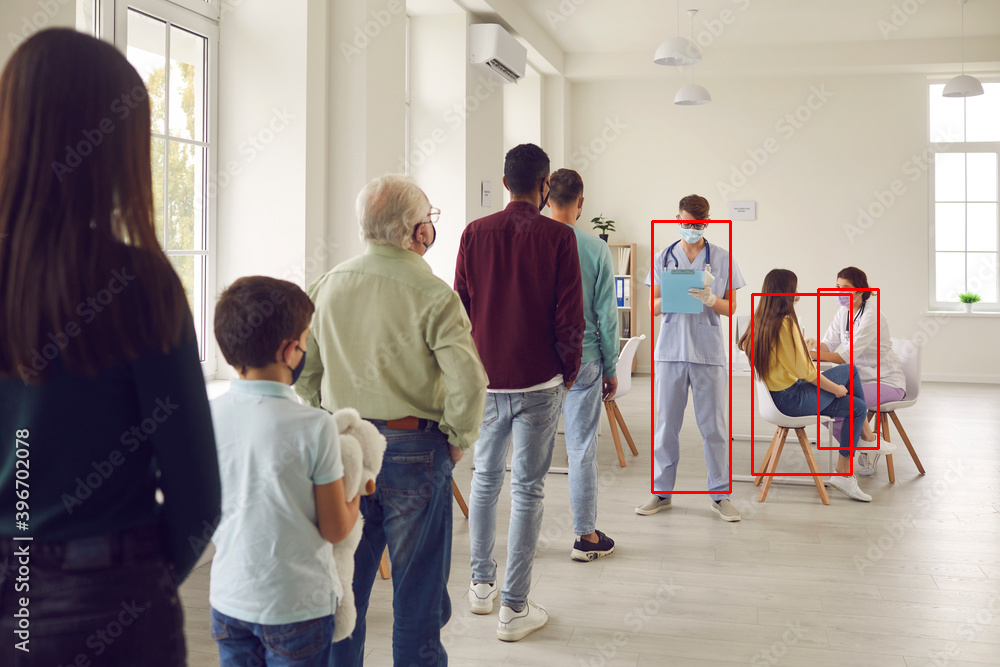

[2521.830141481431, 2328.8692686595627, 2364.842115210165, 1965.1374270512729, 3541.2755085848635, 3374.4023187188495, 3374.4023187188495] [ 90  58  64   0 255 228 228] 90.0


In [11]:
process_image("Q3_pose5.jpg")


image 1/1 /content/Q3_pose6.jpg: 544x640 8 persons, 329.7ms
Speed: 8.2ms preprocess, 329.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

 7 Persons detected.


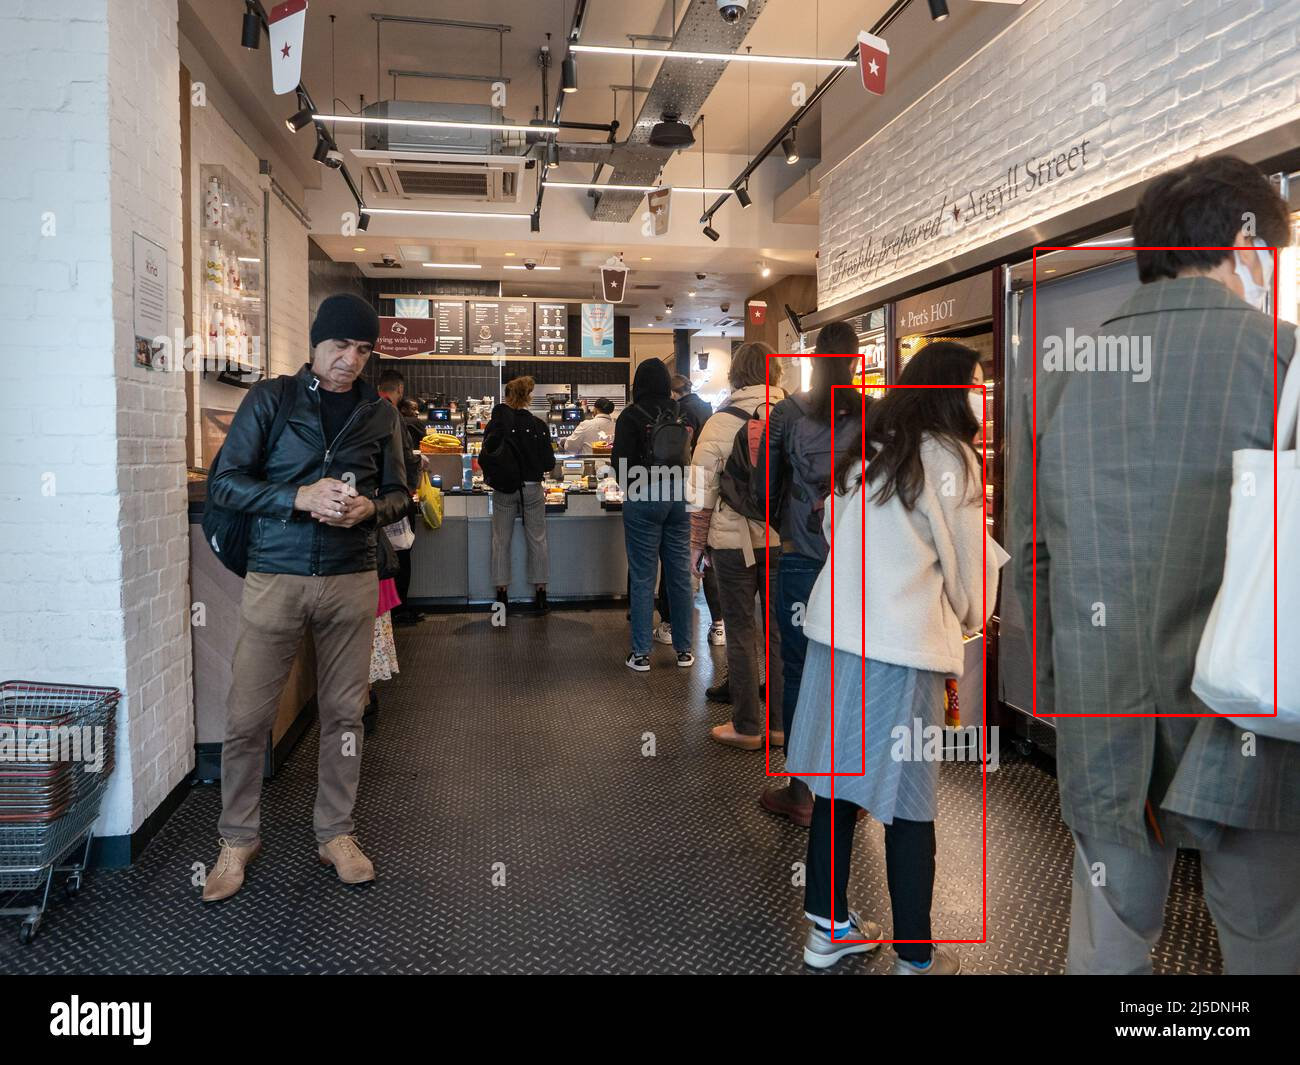

[3940.2779934340197, 3937.04972587285, 4096.357329243219, 4078.1638184124895, 5836.502063989863, 5711.499432216936, 5711.499432216936] [  0   0  21  18 255 238 238] 21.0


In [12]:
process_image("Q3_pose6.jpg")


image 1/1 /content/Q3_pose8.jpg: 480x640 10 persons, 191.4ms
Speed: 3.4ms preprocess, 191.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

 10 Persons detected.


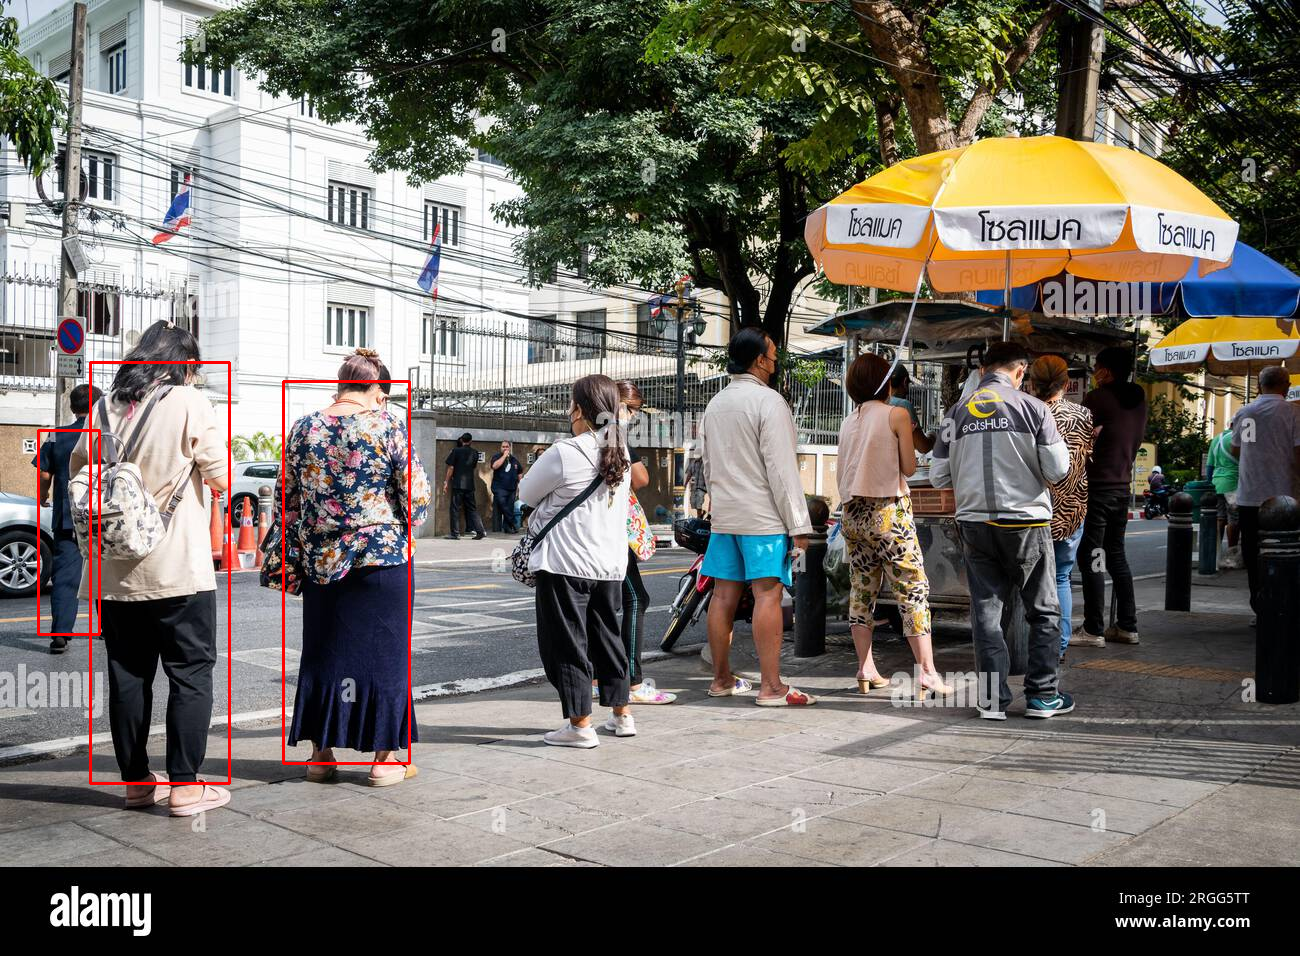

[1774.33070396059, 1773.510413932721, 1774.5333532367595, 1551.7019837736593, 1552.2651210254955, 1525.4024997780616, 1657.493427579083, 1567.0150484666292, 1575.7390597376286, 1575.7390597376286] [254 253 255  26  27   0 135  42  51  51] 135.0


In [13]:
process_image("Q3_pose8.jpg")